# Data Science Project: Planning Stage (Individual)

**Name:** Mervin  
**Course:** DSCI 100 — Data Science Project  
**Topic:** Predicting Usage of a Video Game Research Server  

This notebook presents my individual planning report for the Minecraft research server project.  
I describe the datasets, state my research questions, explore the data, and propose an analytical plan.  
No predictive modelling is performed here.


In [10]:
library(tidyverse)

players  <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

dim(players)
dim(sessions)
glimpse(players)
glimpse(sessions)


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 196   7

[1] 1535    5

Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+

## (1) Data Description

Two datasets are provided by a UBC Computer Science research group studying player behaviour in Minecraft:

- **`players.csv`** — one row per player, containing demographic or registration variables and cumulative gameplay information.  
- **`sessions.csv`** — one row per play session, containing session length, start/end time, and player ID.

**Basic summary**

- `players.csv`: `r nrow(players)` observations and `r ncol(players)` variables  
- `sessions.csv`: `r nrow(sessions)` observations and `r ncol(sessions)` variables

| Variable | Type | Description | Potential Issues |
|-----------|------|--------------|------------------|
| player_id | character | Unique player identifier | Must match between both datasets |
| total_playtime | numeric | Total hours of playtime per player | Likely right-skewed; may contain outliers |
| newsletter_subscribed | logical | Whether the player subscribed to updates | Possibly unbalanced classes |
| ... | ... | Other demographic or behavioural variables | Missing values or inconsistencies |

**Notes**

The data were collected automatically from a Minecraft research server. This method avoids self-report bias but introduces **selection bias** (only those who joined the server). Some players might have partial records if they joined late or disconnected abruptly. Usage variables are expected to be **right-skewed**, and there may be **missing or extreme values** that require cleaning later.


In [11]:
players_summary <- tibble(
  variable = names(players),
  type = sapply(players, function(x) class(x)[1])
)
players_summary


variable,type
<chr>,<chr>
experience,character
subscribe,logical
hashedEmail,character
played_hours,numeric
name,character
gender,character
Age,numeric


In [12]:
players_means <- players |>
  summarise(across(where(is.numeric), ~ mean(.x, na.rm = TRUE))) |>
  pivot_longer(everything(),
               names_to  = "variable",
               values_to = "mean") |>
  mutate(mean = round(mean, 2))

players_means


variable,mean
<chr>,<dbl>
played_hours,5.85
Age,21.14


## (2) Questions

**Broad question:**  
Which types of players contribute the most gameplay data to the Minecraft research server?

**Specific predictive question:**  
Can player characteristics and early gameplay behaviours predict whether a player becomes a *high-usage* player (top 25% of total playtime)?

**Response variable:**  
Binary indicator `high_usage` (1 if total playtime is in top 25%, else 0).

**Explanatory variables:**  
Player-level demographics and behaviour metrics from `players.csv`, such as total sessions, average session length, or region.

**Relevance:**  
This question helps the research team identify which player types are worth targeting in recruitment campaigns and how server resources should be allocated.


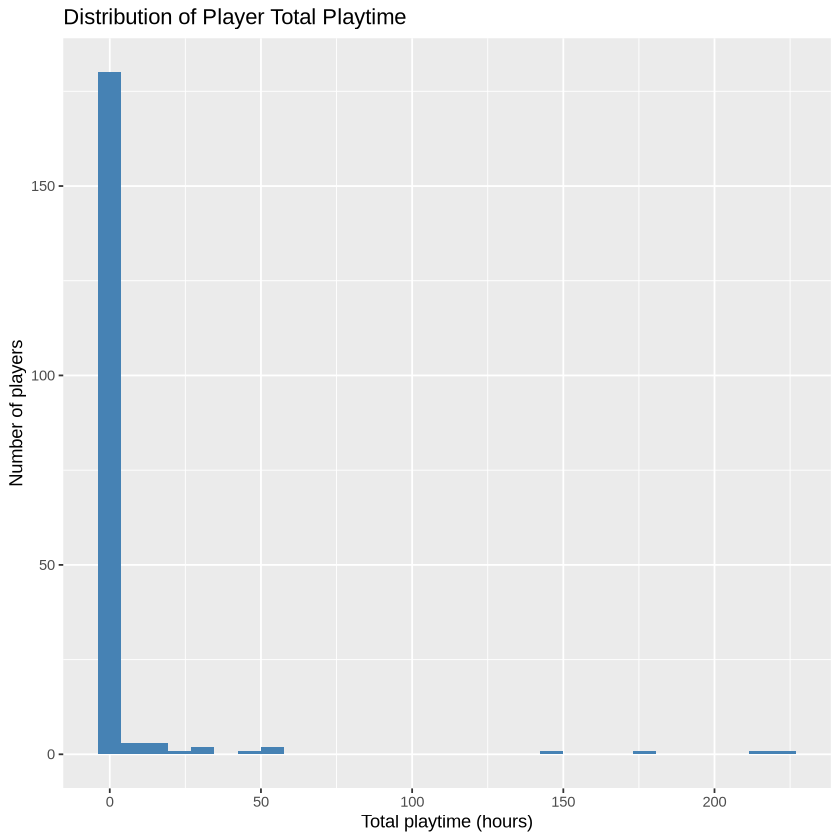

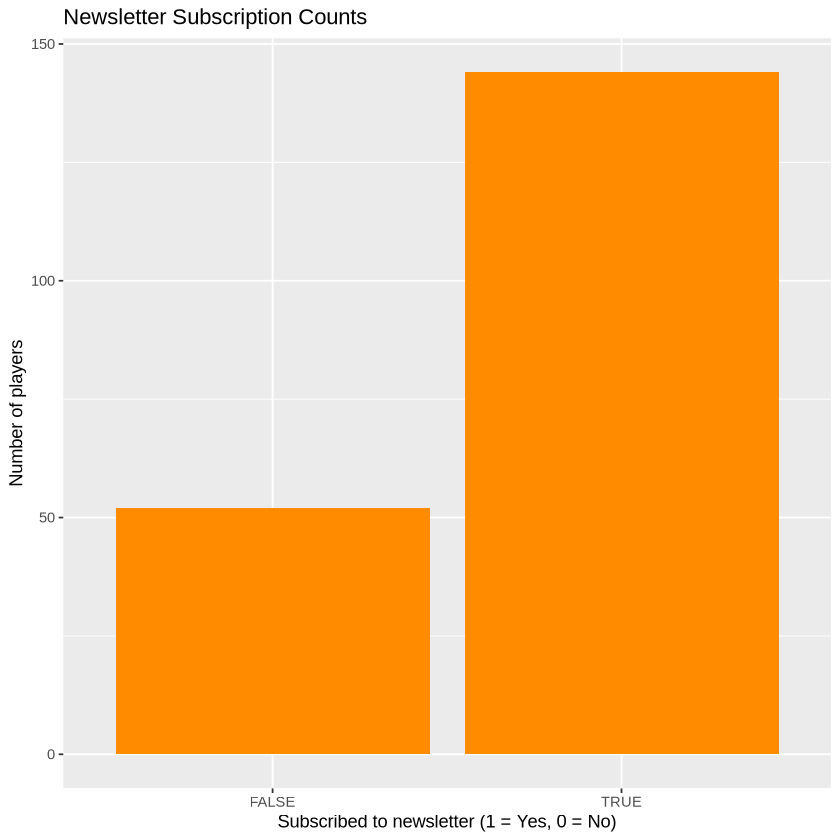

In [15]:
# Histogram of total playtime (actual column name is played_hours)
ggplot(players, aes(x = played_hours)) +
  geom_histogram(bins = 30, fill = "steelblue") +
  labs(
    title = "Distribution of Player Total Playtime",
    x = "Total playtime (hours)",
    y = "Number of players"
  )

# Bar chart for newsletter subscription (actual column name is subscribe)
ggplot(players, aes(x = factor(subscribe))) +
  geom_bar(fill = "darkorange") +
  labs(
    title = "Newsletter Subscription Counts",
    x = "Subscribed to newsletter (1 = Yes, 0 = No)",
    y = "Number of players"
  )


## (3) Exploratory Data Analysis and Visualization

The histogram of total playtime is heavily right-skewed: most players have short playtimes, while a few play extensively.  
This justifies dividing players into “low” and “high” usage groups.

The bar chart of newsletter subscription shows that relatively few players subscribe, suggesting possible class imbalance if this variable is used as a predictor.  

Overall, the exploratory plots confirm that the data vary widely across players and that behavioural variables will likely be more informative than categorical ones.


## (4) Methods and Plan

**Proposed method:**  
I will use *logistic regression* to predict whether a player becomes high-usage (`high_usage = 1`).

**Why appropriate:**  
The response is binary, logistic regression is interpretable, and it estimates probabilities—useful for resource planning and targeted recruitment.

**Assumptions:**  
Observations are independent; log-odds of high usage are linear in the predictors; no perfect multicollinearity.  

**Potential limitations:**  
Behaviour–usage relationships may be non-linear; there may be class imbalance or unmeasured factors like motivation.  

**Model selection and comparison:**  
- Split data into 70% training / 30% testing (stratified by `high_usage`)  
- Perform 5-fold cross-validation on training data to choose the final model  
- Evaluate using accuracy, sensitivity, specificity, and ROC-AUC  

**Processing plan:**  
Define `high_usage` variable → clean missing values → standardize numeric predictors → split dataset → fit and test the logistic regression model.


## (5) GitHub Repository

**Repository link:** [GITHUB_URL_HERE]

Commit history:
1. Initial setup and README  
2. Data loading and cleaning  
3. Variable summary and means  
4. Exploratory plots and observations  
5. Methods and plan section finalized


In [14]:
colnames(players)



[1] "experience"   "subscribe"    "hashedEmail"  "played_hours" "name"        
[6] "gender"       "Age"

In [16]:
git init
git branch -M main
git remote add origin https://github.com/YOURUSERNAME/minecraft-data-science-project.git
git add Mervin_Planning.ipynb
git commit -m "Initial commit: added individual planning notebook"
git push -u origin main


ERROR: Error in parse(text = x, srcfile = src): <text>:1:5: unexpected symbol
1: git init
        ^
